In [8]:
#!pip install tensorflow[and-cuda]

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt

2024-04-17 20:29:12.093994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env = gym.make("Pendulum-v1", render_mode="rgb_array")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype="float32")
        next_state_batch = tf.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)

In [5]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = keras.Model(inputs, outputs)
    return model

def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model

In [6]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

In [17]:
buffer = Buffer(20, 8)

In [62]:
prev_state, _ = env.reset()
tf_prev_state = tf.expand_dims(
            tf.convert_to_tensor(prev_state), 0
        )
action = policy(tf_prev_state, ou_noise)
state, reward, done, truncated, _ = env.step(action)
buffer.record((prev_state, action, reward, state))

record_range = min(buffer.buffer_counter, buffer.buffer_capacity)
batch_indices = np.random.choice(record_range, buffer.batch_size)
state_batch = tf.convert_to_tensor(buffer.state_buffer[batch_indices])
action_batch = tf.convert_to_tensor(buffer.action_buffer[batch_indices])
reward_batch = tf.convert_to_tensor(buffer.reward_buffer[batch_indices])
reward_batch = tf.cast(reward_batch, dtype="float32")
next_state_batch = tf.convert_to_tensor(buffer.next_state_buffer[batch_indices])

# record_range = min(self.buffer_counter, self.buffer_capacity)

<tf.Tensor: shape=(8, 3), dtype=float64, numpy=
array([[-0.57566637, -0.81768465, -0.37354311],
       [ 0.81487262, -0.57964003, -0.47674584],
       [ 0.71011972, -0.70408094, -0.29023471],
       [ 0.99554187,  0.09432067, -0.86569399],
       [ 0.9830116 ,  0.1835435 ,  0.6343919 ],
       [-0.57566637, -0.81768465, -0.37354311],
       [-0.58022147, -0.81445873, -0.74080771],
       [ 0.81487262, -0.57964003, -0.47674584]])>

/mnt/home/khoshne1/anaconda3/envs/my_env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode * 0 * Avg Reward is ==> -1075.348322250855
Episode * 1 * Avg Reward is ==> -975.5742172815405
Episode * 2 * Avg Reward is ==> -1271.023362363299
Episode * 3 * Avg Reward is ==> -1384.1620013671238
Episode * 4 * Avg Reward is ==> -1424.5523875656095
Episode * 5 * Avg Reward is ==> -1420.085517404639
Episode * 6 * Avg Reward is ==> -1441.2243699224596
Episode * 7 * Avg Reward is ==> -1459.3011916414926
Episode * 8 * Avg Reward is ==> -1469.3204073388947
Episode * 9 * Avg Reward is ==> -1479.376991191864
Episode * 10 * Avg Reward is ==> -1444.18772036493
Episode * 11 * Avg Reward is ==> -1407.5813650102275
Episode * 12 * Avg Reward is ==> -1381.1428972903898
Episode * 13 * Avg Reward is ==> -1368.621477376451
Episode * 14 * Avg Reward is ==> -1336.8138647753117
Episode * 15 * Avg Reward is ==> -1293.5068408016573
Episode * 16 * Avg Reward is ==> -1233.101834456538
Episode * 17 * Avg Reward is ==> -1186.4162189309966
Episode * 18 * Avg Reward is ==> -1156.1145578676367
Episode * 19

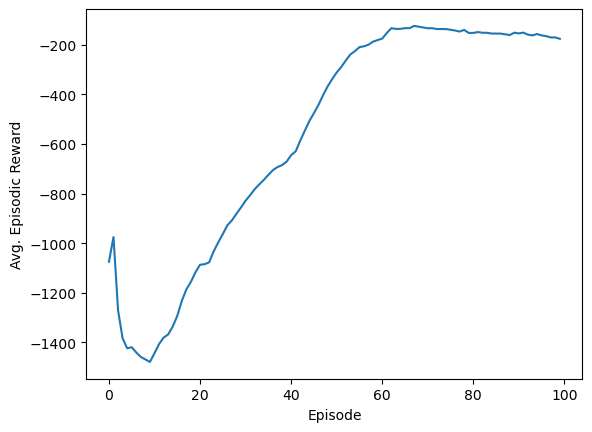

In [16]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(
            tf.convert_to_tensor(prev_state), 0
        )

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, truncated, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` or `truncated` is True
        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()

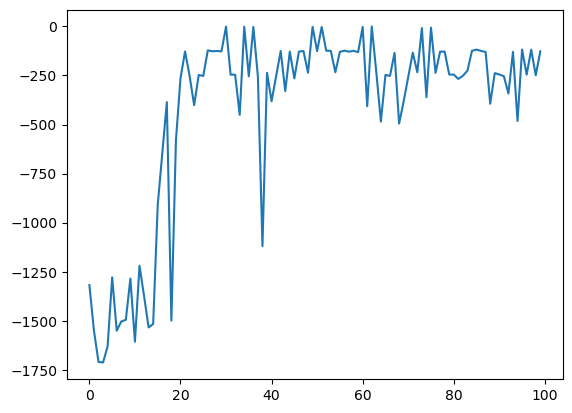

In [15]:
plt.plot(ep_reward_list)

In [17]:
avg_reward_array = np.array(avg_reward_list)
ep_reward_array = np.array(ep_reward_list)
np.save('avg_reward_array.npy', avg_reward_array)
np.save('ep_reward_array.npy', ep_reward_array)